In [3]:
!aws s3 sync s3://deeseadata/style/*  style_paths/

In [1]:
!pip install tensorflow_hub

     |████████████████████████████████| 102kB 4.4MB/s ta 0:00:011
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tensorflow_hub as hub
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

TF Version:  2.0.0
TF-Hub version:  0.8.0
Eager mode enabled:  True
GPU available:  True


# New version

In [5]:
from PIL import Image
import numpy as np
def create_content_batch_tf(path, batch_size = 1):
    img = Image.open(path)
    img_array = np.asarray(img)/255.
    img_array = np.expand_dims(img_array, axis=0)
    img_batch = np.repeat(img_array, batch_size, axis=0)
    return tf.convert_to_tensor(img_batch, dtype=float32)


def create_style_batch_tf(paths, batch_size=1, index=0):
    img_batch = np.zeros([batch_size, 256, 256, 3])
    counter = 0
    all_counter = index
    file_indexes = []
    while counter < batch_size:
        try:
            img = Image.open(paths[all_counter]).resize((256, 256))
            img_array = np.asarray(img)/255.
            img_batch[counter] = img_array
            counter += 1
            file_indexes.append(all_counter)
        except:
            pass
        all_counter +=1
            
    return tf.convert_to_tensor(img_batch, dtype=float32), file_indexes, all_counter

In [6]:
!ls -lathr

total 23M
drwxrwxr-x 2 ec2-user ec2-user  12K Apr  4 23:30 style_paths
-rw-rw-r-- 1 ec2-user ec2-user  440 Apr  5 20:30 sample.py
-rw-rw-r-- 1 ec2-user ec2-user  546 Apr  5 20:30 resize_image.py
drwxrwxr-x 2 ec2-user ec2-user 364K Apr  5 22:37 train_resize
drwxrwxr-x 2 ec2-user ec2-user 4.0K Apr  6 23:55 .ipynb_checkpoints
-rw-rw-r-- 1 ec2-user ec2-user 3.0M Apr  7 17:03 0_0263.jpg
-rw-rw-r-- 1 ec2-user ec2-user 3.0M Apr  7 17:23 0_0007.jpg
-rw-rw-r-- 1 ec2-user ec2-user 3.1M Apr  7 17:27 0_0010.jpg
-rw-rw-r-- 1 ec2-user ec2-user 3.1M Apr  7 17:57 0_0074.jpg
-rw-rw-r-- 1 ec2-user ec2-user 3.0M Apr  7 18:29 0_0103.jpg
-rw-rw-r-- 1 ec2-user ec2-user 2.9M Apr  7 19:22 0_0202.jpg
-rw-rw-r-- 1 ec2-user ec2-user 3.1M Apr 18 20:54 0_0420.jpg
-rw-rw-r-- 1 ec2-user ec2-user 1.4M Apr 18 22:19 transfer.ipynb
drwxrwxr-x 7 ec2-user ec2-user 4.0K Apr 18 22:22 .
drwxr-xr-x 6 ec2-user ec2-user 4.0K Apr 25 21:30 ..
drwxrwxr-x 4 ec2-user ec2-user 4.0K Apr 25 21:33 output
drwxrwxr-x 8 ec2-user ec2-user 4

In [7]:
import glob
import os
import random

N_sample = 50

def save_image(image, filename):
    im = Image.fromarray((image * 255).astype(np.uint8))
    im.save(f"{filename}")
    
    
content_path = 'modern.jpg'
style_paths = "train_resize"

output_dir = "output/04252020"
output_dir_run = os.path.join(output_dir, content_path[:-4])

if not os.path.exists(output_dir_run):
    os.makedirs(output_dir_run)
    
batch_size = 1
content_image_tensor = create_content_batch_tf(content_path, batch_size)
styles = [f for f in glob.glob(style_paths + "/*.jpg", recursive=False)]

styles = random.sample(styles, N_sample)

In [ ]:
!ls output/04072020/0_0202.jpg/

In [8]:
%%time
counter = 0
N = len(styles) // batch_size

for batch_run in range(N):
    print("Running batch: ", batch_run)
    style_image_tensor, file_indexes, counter = create_style_batch_tf(
        styles,  batch_size=batch_size, index = counter)
    hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
    combined_result = hub_module(tf.constant(content_image_tensor), tf.constant(style_image_tensor))
    
    for i, j in enumerate(file_indexes):
        filename = os.path.join(output_dir_run, styles[j][len(style_paths) + 1:])
        img = combined_result[0][i].numpy()
        save_image(img, filename)
    
    if counter >= len(styles):
        break
print("Done")

Running batch:  0
Running batch:  1
Running batch:  2
Running batch:  3
Running batch:  4
Running batch:  5
Running batch:  6
Running batch:  7
Running batch:  8
Running batch:  9
Running batch:  10
Running batch:  11
Running batch:  12
Running batch:  13
Running batch:  14
Running batch:  15
Running batch:  16
Running batch:  17
Running batch:  18
Running batch:  19
Running batch:  20
Running batch:  21
Running batch:  22
Running batch:  23
Running batch:  24
Running batch:  25
Running batch:  26
Running batch:  27
Running batch:  28
Running batch:  29
Running batch:  30
Running batch:  31
Running batch:  32
Running batch:  33
Running batch:  34
Running batch:  35
Running batch:  36
Running batch:  37
Running batch:  38
Running batch:  39
Running batch:  40
Running batch:  41
Running batch:  42
Running batch:  43
Running batch:  44
Running batch:  45
Running batch:  46
Running batch:  47
Running batch:  48
Done
CPU times: user 6min 37s, sys: 59 s, total: 7min 36s
Wall time: 6min 55s


In [ ]:
!ls

# Done

In [38]:
!aws s3 sync output.tgz s3://deeseadata/output/  

OSError: [Errno 12] Cannot allocate memory

In [63]:
len(styles)//8

35

In [59]:
mv  styles style_paths/building.jpg

In [40]:
img = combined_result[0].numpy()
    

In [46]:
len(combined_result)

1

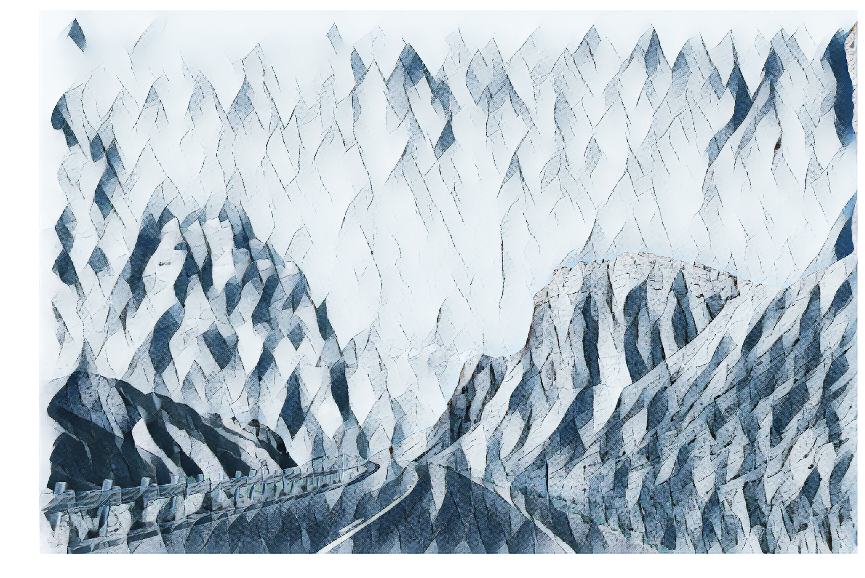

In [14]:
tensor_to_image(combined_result[0])

In [5]:

def image_to_tensor(path_to_img, size=[256, 256], reshape=False):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
    
    # Resize the image to specific dimensions
    if reshape: img = tf.image.resize(img, size)
    img = img[tf.newaxis, :]
    return img


def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    tensor = tensor[0]
    plt.figure(figsize=(20,10))
    plt.axis('off')
    return plt.imshow(tensor)

In [11]:
from PIL import Image

def generate_image(content_path, style_path):
    content_image_tensor = image_to_tensor(content_path)
    style_image_tensor = image_to_tensor(style_path, reshape=True)
    hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
    combined_result = hub_module(tf.constant(content_image_tensor), tf.constant(style_image_tensor))[0]
    return combined_result[0].numpy()


    
    

In [17]:
import os
import glob
input_dir = "base_style"
output_prefix = "output"
output_dir = os.path.join(input_dir, output_prefix)


if not os.path.exists(output_dir):
    os.makedirs(output_dir)

content_path = 'test_image.jpg'
for style_path in files:
    print(style_path)
    im = generate_image(content_path, style_path)
    save_image(im, os.path.join(output_dir, style_path[11:]))
    


base_style/11598.jpg


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node InceptionV3/Conv2d_1a_3x3/Conv2D (defined at /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_hub/module_v2.py:102) ]] [Op:__inference_pruned_15157]

Function call stack:
pruned


In [167]:
!aws s3 cp base_style/output/*  s3://deeseadata/output


Unknown options: base_style/output/11229.jpg,base_style/output/11349.jpg,base_style/output/11361.jpg,base_style/output/11375.jpg,base_style/output/11407.jpg,base_style/output/11413.jpg,base_style/output/1145.jpg,base_style/output/1151.jpg,base_style/output/11567.jpg,base_style/output/11573.jpg,base_style/output/11598.jpg,base_style/output/11639.jpg,base_style/output/11759.jpg,base_style/output/11765.jpg,base_style/output/11771.jpg,base_style/output/1179.jpg,base_style/output/1186.jpg,base_style/output/1192.jpg,base_style/output/11956.jpg,base_style/output/11981.jpg,s3://deeseadata/output
